# Creating and Backtesting simple Momentum/Contrarian Strategies

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [15]:
data = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2018-01-01 22:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  2070 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


<Axes: title={'center': 'EUR/USD'}, xlabel='time'>

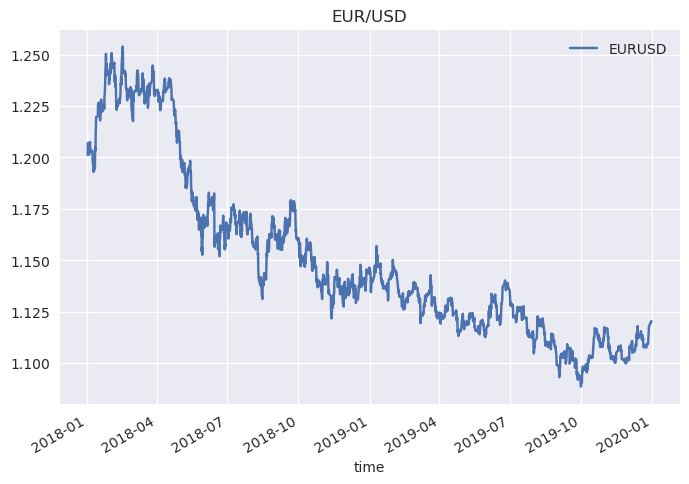

In [17]:
data.plot(title = "EUR/USD")

<Axes: title={'center': 'EUR/USD'}, xlabel='time'>

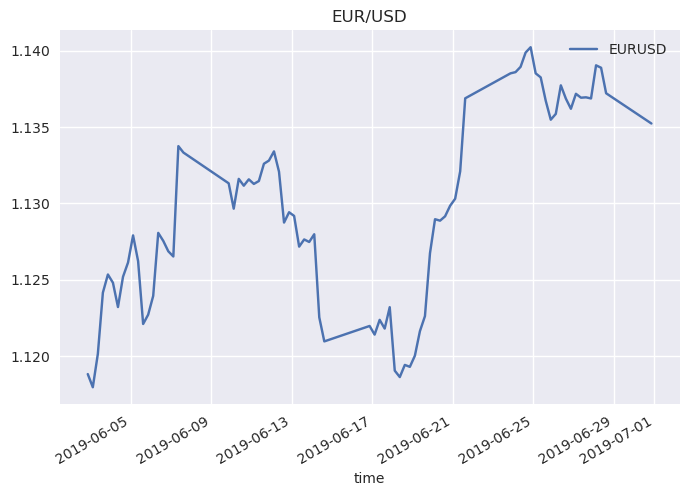

In [18]:
data.loc["2019-06"].plot(title = "EUR/USD")

In [19]:
data["Returns"] = np.log(data.div(data.shift(1)))
data.dropna(inplace = True)
data

,EURUSD,Returns
time,,
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718
...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138


## Intro to Backtesting: a Buy-and-Hold "Strategy"

Assumption: invest $1 in instrument EURUSD on 2018-01-02 and hold until 2019-12-30 (no further traders).

<Axes: xlabel='time'>

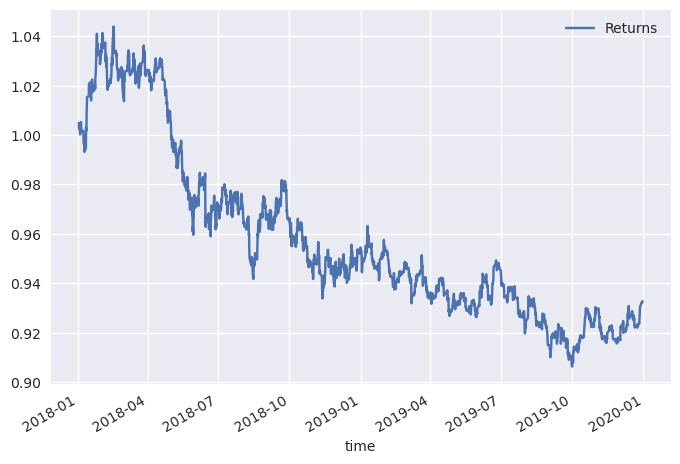

In [22]:
data[["Returns"]].cumsum().apply(np.exp).plot() # normalised price with Base == 1

In [23]:
multiple = data[["Returns"]].sum().apply(np.exp)
multiple

Returns    0.932693
dtype: float64

In [26]:
data.Returns.mean() # 6h mean return

-3.367792182329036e-05

In [25]:
data.Returns.std() # std of 6h return

0.001888428384199011

## Defining a simple Contrarian Strategy (window = 3)

In [30]:
window = 3

In [31]:
data["Returns"].rolling(window).mean()

time
2018-01-02 04:00:00+00:00             NaN
2018-01-02 10:00:00+00:00             NaN
2018-01-02 16:00:00+00:00    1.272676e-03
2018-01-02 22:00:00+00:00   -6.537454e-04
2018-01-03 04:00:00+00:00   -1.702470e-04
                                 ...     
2019-12-29 22:00:00+00:00    1.808598e-03
2019-12-30 04:00:00+00:00    1.085156e-03
2019-12-30 10:00:00+00:00    7.492899e-04
2019-12-30 16:00:00+00:00   -1.484453e-17
2019-12-30 22:00:00+00:00    1.234956e-04
Name: Returns, Length: 2069, dtype: float64

In [32]:
data["Position"] = -np.sign(data["Returns"].rolling(window).mean()) # contrarian (minus sign)
data

,EURUSD,Returns,Position
time,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0
...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0


## Vectorised Strategy Backtesting

In [33]:
data["Strategy"] = data.Position.shift(1) * data.Returns # position to take for the next bar (candle) - use shift(1)
data

,EURUSD,Returns,Position,Strategy
time,,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,NaN,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,NaN,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0,NaN
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718
...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138


In [34]:
data.dropna(inplace = True)
data

,EURUSD,Returns,Position,Strategy
time,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004
...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138


In [35]:
data[["Returns", "Strategy"]].sum().apply(np.exp) # multiple for buy-and-hold and strategy

Returns     0.929138
Strategy    1.101019
dtype: float64

In [37]:
data["creturns"] = data["Returns"].cumsum().apply(np.exp)  # normalized price with base = 1 for buy-and-hold
data["cstrategy"] = data["Strategy"].cumsum().apply(np.exp) # normalized price with base = 1 for strategy

<Axes: xlabel='time'>

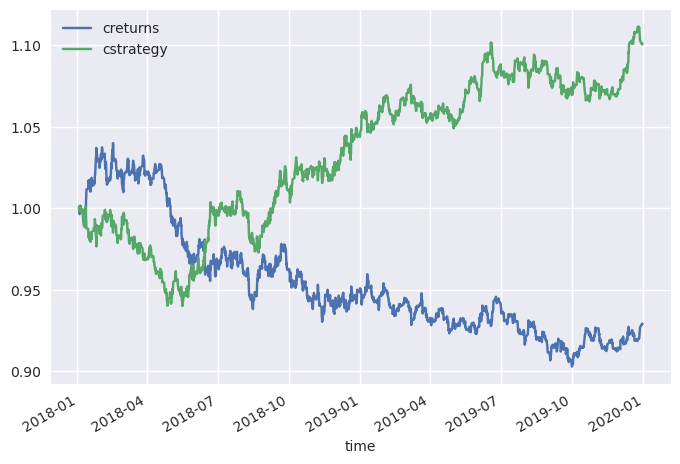

In [39]:
data[["creturns", "cstrategy"]].plot()

In [41]:
tp_year = data.Returns.count() / ((data.index[-1] - data.index[0]).days / 365.25) # 6h trading periods
tp_year

1037.9731774415407

In [42]:
data[["Returns", "Strategy"]].mean() * tp_year # annualised returns

Returns    -0.036926
Strategy    0.048350
dtype: float64

In [45]:
data[["Returns", "Strategy"]].std() * np.sqrt(tp_year) # annualised stf

Returns     0.060761
Strategy    0.060754
dtype: float64

All long/short trading strategies (either -1 or 1) based on the underlying instrument have the same risk.
Risk (std) can be reduced with **neutral positions (0)**.